# Train WPD2 (WebPage Domain) detection model for phishing detection

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../phi_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-12-11_18;40;33.772059


## Params

In [32]:
model_name = "wpd2"
batch_size = 16
img_height = 256
img_width = 512 

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [6]:
train_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'trusted_list',
  validation_split=rest_split_ratio,
  subset="training",
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9346 files belonging to 155 classes.
Using 7477 files for training.


In [7]:
rest_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'trusted_list',
  #label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9346 files belonging to 155 classes.
Using 1869 files for validation.


In [14]:
class_names = train_trusted_ds.class_names
num_classes = len(class_names)

In [8]:
train_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'phishing',
  validation_split=rest_split_ratio,
  subset="validation",
  #label_mode = 'categorical',
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1195 files belonging to 155 classes.
Using 239 files for validation.


In [9]:
rest_phi_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/'phishing',
  validation_split=rest_split_ratio,
  subset="validation",
  #label_mode = 'categorical',
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1195 files belonging to 155 classes.
Using 239 files for validation.


In [10]:
train_ds = train_trusted_ds.concatenate(train_phi_ds)
rest_ds = rest_trusted_ds.concatenate(rest_phi_ds)

In [11]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

132


In [12]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [15]:
print(class_names, num_classes)

['absa', 'adidas', 'adobe', 'airbnb', 'alibaba', 'aliexpress', 'allegro', 'amazon', 'ameli_fr', 'american_express', 'anadolubank', 'aol', 'apple', 'arnet_tech', 'aruba', 'att', 'azul', 'bahia', 'banco_de_occidente', 'banco_inter', 'bankia', 'barclaycard', 'barclays', 'bbt', 'bcp', 'bestchange', 'blizzard', 'bmo', 'bnp_paribas', 'bnz', 'boa', 'bradesco', 'bt', 'caixa_bank', 'canada', 'capital_one', 'capitec', 'cathay_bank', 'cetelem', 'chase', 'cibc', 'cloudconvert', 'cloudns', 'cogeco', 'commonwealth_bank', 'cox', 'crate_and_barrel', 'cryptobridge', 'daum', 'db', 'dhl', 'dkb', 'docmagic', 'dropbox', 'ebay', 'eharmony', 'erste', 'etisalat', 'etrade', 'facebook', 'fibank', 'file_transfer', 'fnac', 'fsnb', 'godaddy', 'google', 'google_drive', 'gov_uk', 'grupo_bancolombia', 'hfe', 'hsbc', 'htb', 'icloud', 'ics', 'ieee', 'impots_gov', 'infinisource', 'instagram', 'irs', 'itau', 'itunes', 'knab', 'la_banque_postale', 'la_poste', 'latam', 'lbb', 'lcl', 'linkedin', 'lloyds_bank', 'made_in_chin

In [16]:
train_ds.cardinality().numpy()

483

In [17]:
val_ds.cardinality().numpy()

106

In [18]:
test_ds.cardinality().numpy()

26

## Visualize data

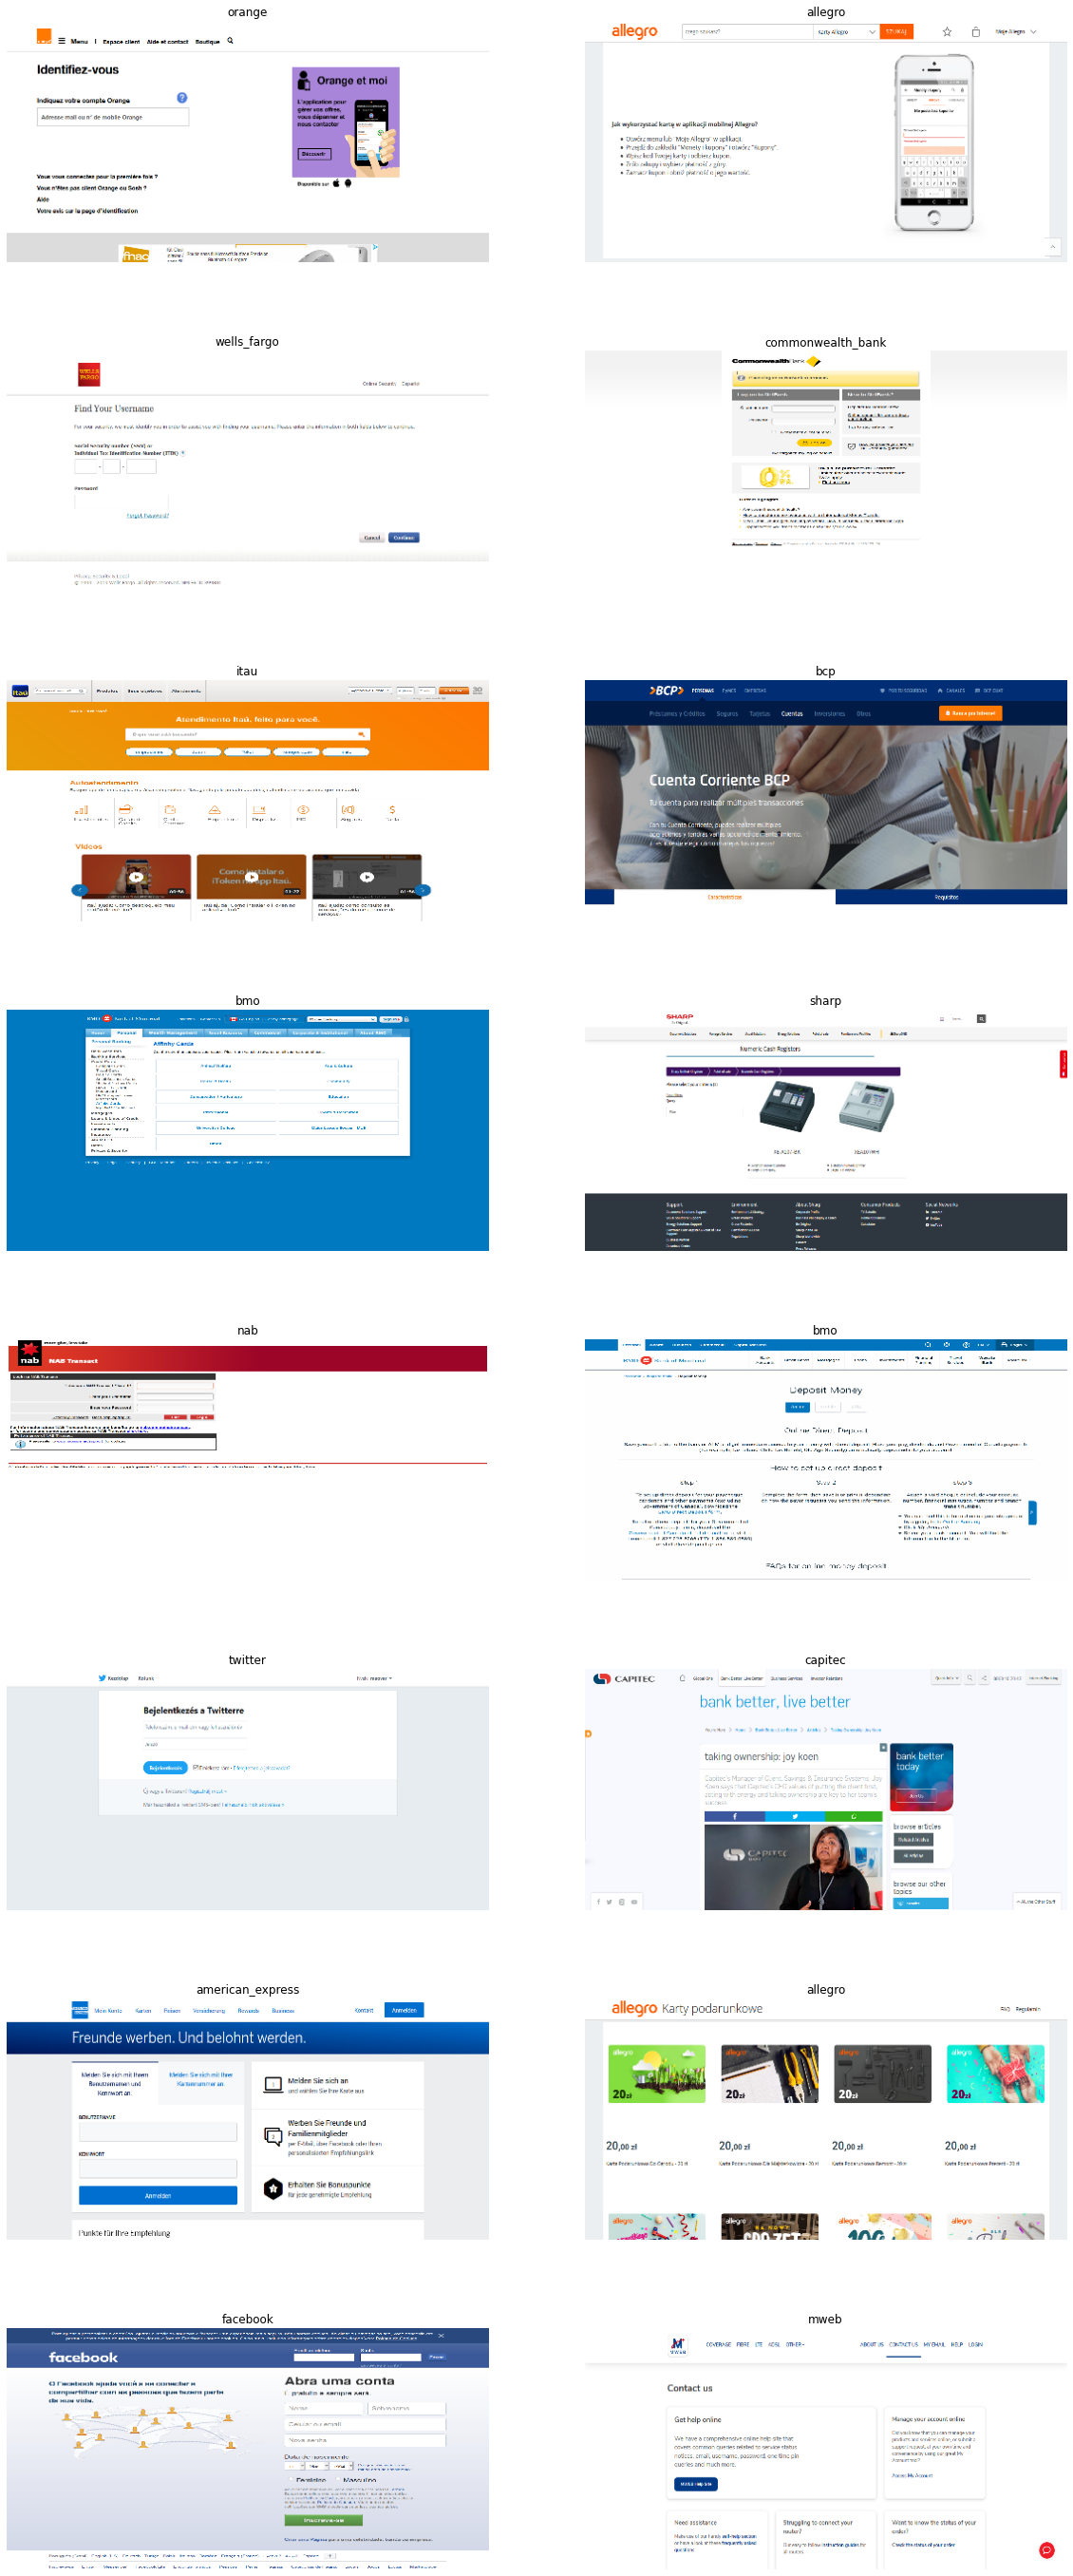

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
#print(train_ds.take(1)[2])
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(512).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarize the dataset

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Model

In [22]:
#num_classes = 2
dropout_prob1 = 0.4
dropout_prob2 = 0.5
reg_rate1 = 0.005
reg_rate2 = 0.001
model = Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3),
#                 activity_regularizer=regularizers.l2(reg_rate1)
               ),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu',
#                activity_regularizer=regularizers.l2(reg_rate1)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob1),
  layers.Conv2D(64, 3, padding='same', activation='relu',
#                activity_regularizer=regularizers.l2(reg_rate2)
               ),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Flatten(),
  layers.Dense(256, activation='relu',
#               activity_regularizer=regularizers.l2(reg_rate2)
              ),
  layers.Dense(num_classes)
])


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 512, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 128, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 128, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 64, 64)        0

## Training

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10
483/483 [==============================] - 123s 103ms/step - loss: 3.5587 - accuracy: 0.3271 - val_loss: 1.9471 - val_accuracy: 0.6087

Epoch 00001: val_loss improved from inf to 1.94707, saving model to ..\phi_checkpoints\2021-12-11_18;40;33.772059_wpd1_valacc0.6087_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-12-11_18;40;33.772059_wpd1_valacc0.6087_e1\assets
Epoch 2/10
483/483 [==============================] - 31s 63ms/step - loss: 1.2837 - accuracy: 0.7320 - val_loss: 0.6939 - val_accuracy: 0.8688

Epoch 00002: val_loss improved from 1.94707 to 0.69390, saving model to ..\phi_checkpoints\2021-12-11_18;40;33.772059_wpd1_valacc0.8688_e2
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-12-11_18;40;33.772059_wpd1_valacc0.8688_e2\assets
Epoch 3/10
483/483 [==============================] - 25s 53ms/step - loss: 0.4054 - accuracy: 0.9049 - val_loss: 0.3483 - val_accuracy: 0.9462

Epoch 00003: val_loss improved from 0.69390 to 0.34835, saving model to

## Save model

In [33]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2021-12-11_18;40;33.772059_wpd2_valacc0.9462_e8_b16.tf\assets


## Load model

In [29]:
# change filename to the model you want to load
model_filename = "2021-12-11_18;40;33.772059_wpd2_valacc0.9462_e8_b16.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [28]:
history.history

{'loss': [3.5586512088775635,
  1.2837470769882202,
  0.4053688943386078,
  0.13875135779380798,
  0.09530889242887497,
  0.09796372801065445,
  0.09104146808385849,
  0.054344359785318375],
 'accuracy': [0.32711249589920044,
  0.7319855093955994,
  0.9048730134963989,
  0.963970959186554,
  0.9748574495315552,
  0.975246250629425,
  0.9771902561187744,
  0.9854847192764282],
 'val_loss': [1.9470680952072144,
  0.6938967704772949,
  0.348346084356308,
  0.304781973361969,
  0.3133074939250946,
  0.3566032648086548,
  0.33550581336021423,
  0.4730817675590515],
 'val_accuracy': [0.6087470650672913,
  0.868794322013855,
  0.9462174773216248,
  0.957446813583374,
  0.9556737542152405,
  0.9586288332939148,
  0.9621749520301819,
  0.9462174773216248]}

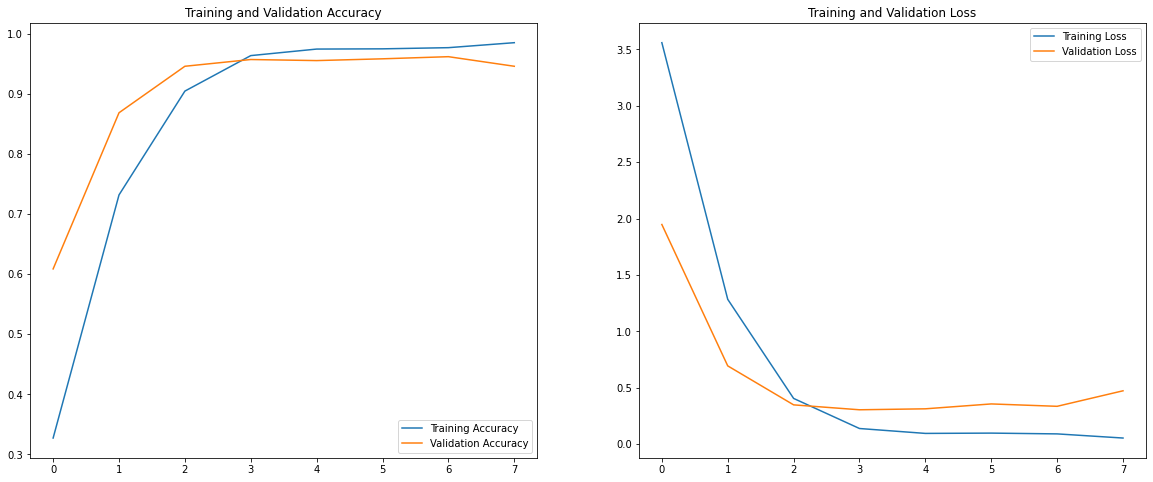

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [30]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

106/106 [==============================] - 2s 18ms/step - loss: 0.4731 - accuracy: 0.9462
val loss, val acc: [0.4730817675590515, 0.9462174773216248]


In [31]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


26/26 [==============================] - 5s 138ms/step - loss: 0.3484 - accuracy: 0.9615
test loss, test acc: [0.3484153747558594, 0.9615384340286255]
